# Libraries

In [1]:
# General-purpose imports
import pickle
import numpy as np
import pandas as pd
from os.path import exists
from collections import Counter
import string

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from nltk.corpus import stopwords

# Machine Learning model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
# Model evaluation and selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

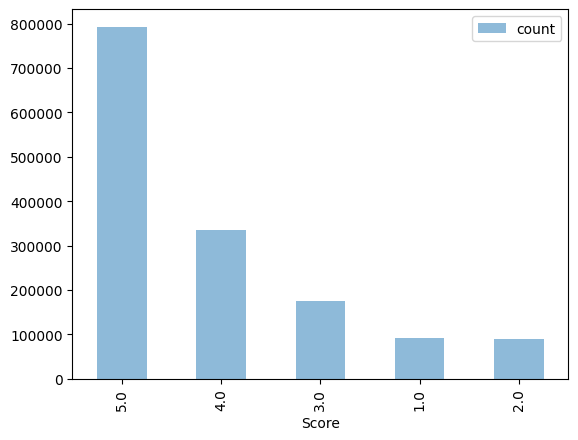


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
train_df= pd.read_csv("./data/train.csv")
trainingSet = train_df
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [3]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/simonwang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Adding Features

In [4]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob  # For sentiment analysis

import pandas as pd
import numpy as np

# Define negation and positive word lists
negation_words = ["not",  "never", "none", "cannot", "can't", "won't", "didn't"]
positive_words = ["good", "great", "excellent", "love", "amazing", "wonderful", "best", "fantastic", "perfect"]

def detect_negation(text):
    """Return 1 if any negation word is detected, otherwise 0."""
    text = text.lower()
    return 1 if any(neg_word in text for neg_word in negation_words) else 0

def detect_positive(text):
    """Return 1 if any positive word is detected, otherwise 0."""
    text = text.lower()
    return 1 if any(pos_word in text for pos_word in positive_words) else 0

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()
def feature_engineering(train_df):
    """
    Enhanced feature engineering with additional text, statistical, temporal, and engagement features.
    """
    # Fill missing text fields
    train_df['Text'] = train_df['Text'].fillna('')
    train_df['combined_text'] = train_df['Text'].apply(preprocess_text)  # Apply preprocessing

    # Negation and positive word detection flags
    train_df['negation_flag'] = train_df['combined_text'].apply(detect_negation) *2
    train_df['positive_flag'] = train_df['combined_text'].apply(detect_positive) *2
    
    # New feature: net positive flag
    train_df['net_positive_flag'] = train_df['positive_flag'] - train_df['negation_flag']


    # Helpfulness and engagement features
    train_df['HelpfulnessRatio'] = np.where(
        train_df['HelpfulnessDenominator'] > 0,
        train_df['HelpfulnessNumerator'] / train_df['HelpfulnessDenominator'],
        0
    )
    train_df['helpful_votes'] = train_df['HelpfulnessNumerator']
    train_df['total_votes'] = train_df['HelpfulnessDenominator']

    # Select relevant features
    combined_features = train_df[[
        'negation_flag', 'positive_flag', 'net_positive_flag',  'HelpfulnessRatio', 'helpful_votes', 'total_votes'
    ]]
    
    return combined_features
def preprocess_text(text):
    """Convert text to lowercase, remove punctuation, and filter out stopwords."""
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(words)
# Apply feature engineering to the dataset

# Apply feature engineering to the entire dataset without selecting high helpfulness


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/simonwang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Sample + Split into training and testing set



In [5]:
# Step 1: Randomly sample 100,000 rows from train_df
trainingSet = train_df.sample(n=100000, random_state=42).reset_index(drop=True)

# Step 2: Remove rows with NaN values in the 'Score' column
trainingSet = trainingSet.dropna(subset=['Score']).reset_index(drop=True)
print("TrainingSet shape after dropping NaN scores:", trainingSet.shape)

# Step 3: Apply feature engineering to generate X_train
X_train = feature_engineering(trainingSet)
print("Feature engineering on training set completed.")
print(X_train.head())

# Step 4: Define the target variable y_train
y_train = trainingSet['Score'].reset_index(drop=True)
print("Target variable `y_train` extracted.")

TrainingSet shape after dropping NaN scores: (87424, 9)
Feature engineering on training set completed.
   negation_flag  positive_flag  net_positive_flag  HelpfulnessRatio  \
0              0              0                  0               0.0   
1              2              2                  0               0.0   
2              0              2                  2               0.0   
3              0              2                  2               1.0   
4              0              2                  2               1.0   

   helpful_votes  total_votes  
0              0            1  
1              0            0  
2              0            0  
3              1            1  
4              1            1  
Target variable `y_train` extracted.


In [52]:

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd

# Split data into training and validation sets
X_train_data, X_val, y_train_data, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convert to DataFrame for easier manipulation
train_df = pd.DataFrame(X_train_data)
train_df['label'] = y_train_data

# Separate each class for targeted sampling
class_1 = train_df[train_df['label'] == 1]
class_2 = train_df[train_df['label'] == 2]
class_3 = train_df[train_df['label'] == 3]
class_4 = train_df[train_df['label'] == 4]
class_5 = train_df[train_df['label'] == 5]
count_class_4 = class_4.shape[0]
# Calculate target size for classes 1, 2, and 3 (1.8 times the size of class 4)
target_count = int(0.3 * class_4.shape[0])
target_count_5 = int(3 * count_class_4)

# Undersample class 5 to match the target count
class_5_undersampled = resample(class_5, replace=True, n_samples=int(3 * count_class_4), random_state=42)
class_4_undersampled = resample(class_4, replace=True, n_samples=int(1.5*  count_class_4), random_state=42)

# Oversample classes 1, 2, and 3 to match the target count
class_1_oversampled = resample(class_1, replace=True, n_samples=int(0.5* count_class_4), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=int(0.6* count_class_4), random_state=42)
class_3_oversampled = resample(class_3, replace=True, n_samples=int(1* count_class_4), random_state=42)

# Combine all classes back together
train_balanced_df = pd.concat([class_1_oversampled, class_2_oversampled, class_3_oversampled, class_4_undersampled, class_5_undersampled])

# Separate features and target
X_train_balanced = train_balanced_df.drop(columns='label').values
y_train_balanced = train_balanced_df['label'].values

# Confirm the new class distribution
print("Class distribution after oversampling classes 1, 2, and 3:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution after oversampling classes 1, 2, and 3:
5.0    47523
4.0    23761
3.0    15841
2.0     9504
1.0     7920
Name: count, dtype: int64


In [53]:
# Adjust labels to be 0-based
y_train_balanced = y_train_balanced -1
y_train_balanced = y_train_balanced.astype(int)  # Ensure integer type for compatibility
y_val = y_val -1
y_val = y_val.astype(int)


Unique values in y_train_balanced after adjustment: [0 1 2 3 4]
Unique values in y_val after adjustment: [0 1 2 3 4]
[0]	train-mlogloss:1.52408	validation-mlogloss:1.50825
[10]	train-mlogloss:1.28332	validation-mlogloss:1.21047
[20]	train-mlogloss:1.24712	validation-mlogloss:1.16611


/Users/simonwang/myenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[30]	train-mlogloss:1.23761	validation-mlogloss:1.15793
[40]	train-mlogloss:1.23342	validation-mlogloss:1.15688
[47]	train-mlogloss:1.23121	validation-mlogloss:1.15705

Validation Accuracy: 0.551501286817272

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.45      0.44      1087
           1       0.21      0.04      0.07      1039
           2       0.25      0.07      0.10      2045
           3       0.21      0.01      0.01      3961
           4       0.58      0.96      0.72      9353

    accuracy                           0.55     17485
   macro avg       0.34      0.30      0.27     17485
weighted avg       0.42      0.55      0.43     17485



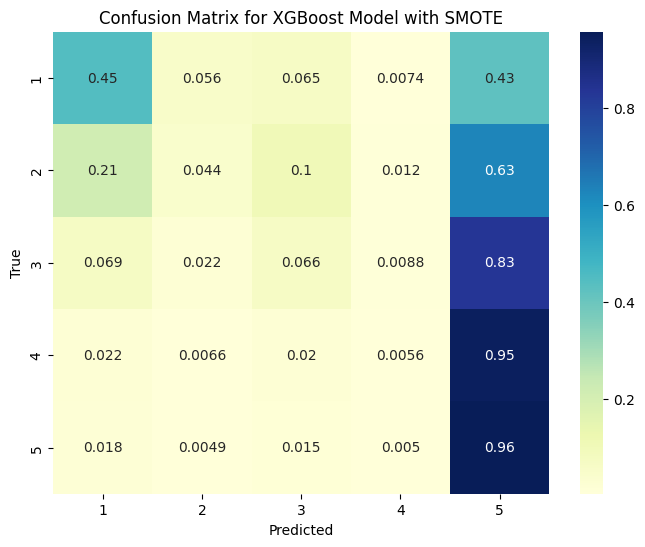

In [54]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("Unique values in y_train_balanced after adjustment:", np.unique(y_train_balanced))
print("Unique values in y_val after adjustment:", np.unique(y_val))

# Ensure num_class is exactly 5 if labels are in [0, 4]
params = {
    'objective': 'multi:softmax',
    'num_class': 5,  # Set to 5 if labels are [0, 4]
    'max_depth': 5,
    'learning_rate': 0.2,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss',
    'seed': 42
}

# Scale features
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
# Adjust labels to be 0-based

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_balanced_scaled, label=y_train_balanced)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

# Train the XGBoost model with early stopping
num_rounds = 100
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=5,
    verbose_eval=10
)

# Make predictions on the validation set
y_val_pred = model.predict(dval)
y_val_pred = y_val_pred.astype(int)

# Evaluate model performance
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title('Confusion Matrix for XGBoost Model with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [60]:
train_df= pd.read_csv("./data/train.csv")


# Step 1: Merge test and train data on 'Id' to create `merged_data`
merged_data = pd.merge(testingSet, train_df, on='Id', how='left')
print("Merged data shape:", merged_data.shape)

# Step 2: Apply feature engineering to generate `X_test`
X_test = feature_engineering(merged_data)

# Step 3: Scale the test data features using the same scaler fitted on training data
X_test_scaled = scaler.transform(X_test)



Merged data shape: (212192, 10)


/Users/simonwang/myenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'numpy.ndarray'>)

In [62]:
dtest = xgb.DMatrix(X_test_scaled)

# Make predictions on the test set using DMatrix
y_test_pred = model.predict(dtest).astype(int)+1
print("Predictions for `X_test`:", y_test_pred)

# Generate the final submission file
submission = pd.DataFrame({
    "Id": testingSet['Id'],
    "Score": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")
print("Submission shape:", submission.shape)



Predictions for `X_test`: [5 5 5 ... 5 5 5]
Submission file created: submission.csv
Submission shape: (212192, 2)
